In [1]:
from typing import List, Dict, Optional
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

# Load Model Weights (may take a few minutes)

In [2]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
tokenizer = stable.tokenizer

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/hilac/miniconda3/envs/myldm/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


# Pipeline Wrapper

In [3]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0:0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False,
                    sd_2_1: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter,
                       sd_2_1=sd_2_1)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Run Inference on a Set of Seeds and Generate an Image Grid

In [4]:
def generate_images_for_method(prompt: str,
                               seeds: List[int],
                               indices_to_alter: Optional[List[int]] = None,
                               is_attend_and_excite: bool = True,
                               sd_2_1: bool = False):
    token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None else indices_to_alter
    images = []
    for seed in seeds:
        g = torch.Generator('cuda').manual_seed(seed)
        prompts = [prompt]
        controller = AttentionStore()
        run_standard_sd = False if is_attend_and_excite else True
        image = run_and_display(prompts=prompts,
                                controller=controller,
                                indices_to_alter=token_indices,
                                generator=g,
                                run_standard_sd=run_standard_sd,
                                sd_2_1=sd_2_1)
        images.append(image.resize((256, 256)))
    grid = vis_utils.get_image_grid(images)
    display(grid)

# Stable Diffusion vs. Attend-and-Excite

## Stable Diffusion

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'frog']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

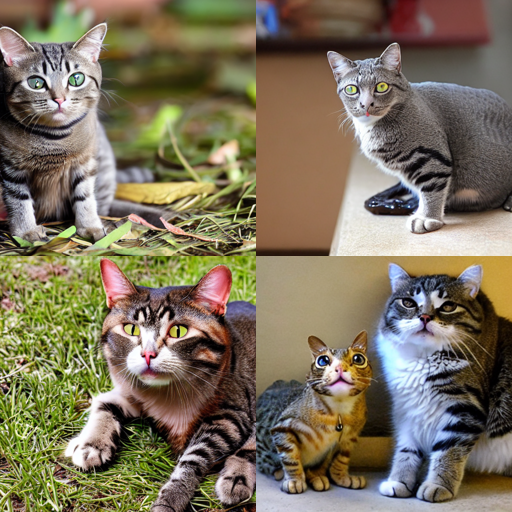

In [5]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=False
)

## Attend-and-Excite

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'frog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'frog']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0268
Iteration 1 | Loss: 0.0302
Iteration 2 | Loss: 0.0306
Iteration 3 | Loss: 0.0104
Iteration 4 | Loss: 0.0119
Iteration 5 | Loss: 0.0098
Iteration 6 | Loss: 0.0133
Iteration 7 | Loss: 0.0071
Iteration 8 | Loss: 0.0235
Iteration 9 | Loss: 0.0060
Iteration 10 | Loss: 0.0323
Iteration 11 | Loss: 0.0060
Iteration 12 | Loss: 0.0186
Iteration 13 | Loss: 0.0066
Iteration 14 | Loss: 0.0217
Iteration 15 | Loss: 0.0086
Iteration 16 | Loss: 0.0312
Iteration 17 | Loss: 0.0106
Iteration 18 | Loss: 0.0303
Iteration 19 | Loss: 0.0157
Iteration 20 | Loss: 0.0255
Iteration 21 | Loss: 0.0178
Iteration 22 | Loss: 0.0271
Iteration 23 | Loss: 0.0186
Iteration 24 | Loss: 0.0290


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0640
Iteration 1 | Loss: 0.0124
Iteration 2 | Loss: 0.0122
Iteration 3 | Loss: 0.0085
Iteration 4 | Loss: 0.0045
Iteration 5 | Loss: 0.0031
Iteration 6 | Loss: 0.0027
Iteration 7 | Loss: 0.0031
Iteration 8 | Loss: 0.0029
Iteration 9 | Loss: 0.0033
Iteration 10 | Loss: 0.0029
Iteration 11 | Loss: 0.0029
Iteration 12 | Loss: 0.0030
Iteration 13 | Loss: 0.0029
Iteration 14 | Loss: 0.0038
Iteration 15 | Loss: 0.0041
Iteration 16 | Loss: 0.0054
Iteration 17 | Loss: 0.0054
Iteration 18 | Loss: 0.0073
Iteration 19 | Loss: 0.0101
Iteration 20 | Loss: 0.0091
Iteration 21 | Loss: 0.0167
Iteration 22 | Loss: 0.0122
Iteration 23 | Loss: 0.0156
Iteration 24 | Loss: 0.0156


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.1634
Iteration 1 | Loss: 0.1081
Iteration 2 | Loss: 0.1278
Iteration 3 | Loss: 0.0081
Iteration 4 | Loss: 0.0070
Iteration 5 | Loss: 0.0051
Iteration 6 | Loss: 0.0061
Iteration 7 | Loss: 0.0041
Iteration 8 | Loss: 0.0070
Iteration 9 | Loss: 0.0081
Iteration 10 | Loss: 0.0081
Iteration 11 | Loss: 0.0113
Iteration 12 | Loss: 0.0129
Iteration 13 | Loss: 0.0117
Iteration 14 | Loss: 0.0120
Iteration 15 | Loss: 0.0103
Iteration 16 | Loss: 0.0106
Iteration 17 | Loss: 0.0114
Iteration 18 | Loss: 0.0113
Iteration 19 | Loss: 0.0143
Iteration 20 | Loss: 0.0141
Iteration 21 | Loss: 0.0177
Iteration 22 | Loss: 0.0180
Iteration 23 | Loss: 0.0208
Iteration 24 | Loss: 0.0221


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.0831
Iteration 1 | Loss: 0.0092
Iteration 2 | Loss: 0.0090
Iteration 3 | Loss: 0.0062
Iteration 4 | Loss: 0.0051
Iteration 5 | Loss: 0.0058
Iteration 6 | Loss: 0.0047
Iteration 7 | Loss: 0.0244
Iteration 8 | Loss: 0.0056
Iteration 9 | Loss: 0.0077
Iteration 10 | Loss: 0.0077
Iteration 11 | Loss: 0.0090
Iteration 12 | Loss: 0.0095
Iteration 13 | Loss: 0.0106
Iteration 14 | Loss: 0.0105
Iteration 15 | Loss: 0.0136
Iteration 16 | Loss: 0.0122
Iteration 17 | Loss: 0.0162
Iteration 18 | Loss: 0.0157
Iteration 19 | Loss: 0.0149
Iteration 20 | Loss: 0.0202
Iteration 21 | Loss: 0.0164
Iteration 22 | Loss: 0.0201
Iteration 23 | Loss: 0.0200
Iteration 24 | Loss: 0.0218


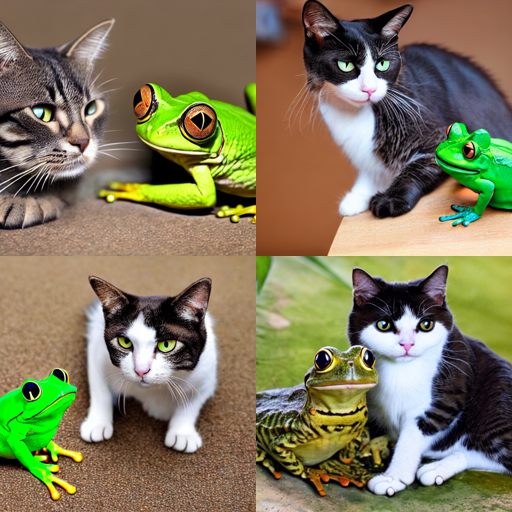

In [6]:
generate_images_for_method(
    prompt="a cat and a frog",
    seeds=[6141, 9031, 969, 1910],
    is_attend_and_excite=True
)

## Stable Diffusion

{1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,6
Altering tokens: ['mouse', 'car']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

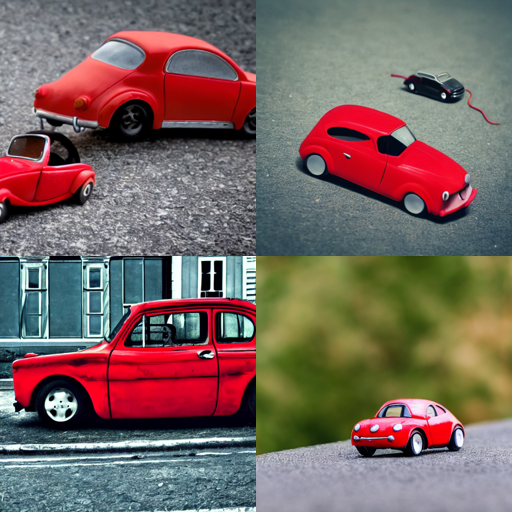

In [7]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=False
)

## Attend-and-Excite

{1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,6
Altering tokens: ['mouse', 'car']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8952
Iteration 1 | Loss: 0.0166
Iteration 2 | Loss: 0.0149
Iteration 3 | Loss: 0.0004
Iteration 4 | Loss: 0.0002
Iteration 5 | Loss: 0.0001
Iteration 6 | Loss: 0.0003
Iteration 7 | Loss: 0.0004
Iteration 8 | Loss: 0.0011
Iteration 9 | Loss: 0.0032
Iteration 10 | Loss: 0.0042
Iteration 11 | Loss: 0.0156
Iteration 12 | Loss: 0.0145
Iteration 13 | Loss: 0.0366
Iteration 14 | Loss: 0.0349
Iteration 15 | Loss: 0.0452
Iteration 16 | Loss: 0.0412
Iteration 17 | Loss: 0.0397
Iteration 18 | Loss: 0.0353
Iteration 19 | Loss: 0.0355
Iteration 20 | Loss: 0.0384
Iteration 21 | Loss: 0.0429
Iteration 22 | Loss: 0.0424
Iteration 23 | Loss: 0.0449
Iteration 24 | Loss: 0.0461


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8401
Iteration 1 | Loss: 0.0049
Iteration 2 | Loss: 0.0042
Iteration 3 | Loss: 0.0037
Iteration 4 | Loss: 0.0032
Iteration 5 | Loss: 0.0018
Iteration 6 | Loss: 0.0036
Iteration 7 | Loss: 0.0046
Iteration 8 | Loss: 0.0069
Iteration 9 | Loss: 0.0098
Iteration 10 | Loss: 0.0102
Iteration 11 | Loss: 0.0142
Iteration 12 | Loss: 0.0134
Iteration 13 | Loss: 0.0147
Iteration 14 | Loss: 0.0163
Iteration 15 | Loss: 0.0155
Iteration 16 | Loss: 0.0201
Iteration 17 | Loss: 0.0196
Iteration 18 | Loss: 0.0244
Iteration 19 | Loss: 0.0247
Iteration 20 | Loss: 0.0283
Iteration 21 | Loss: 0.0293
Iteration 22 | Loss: 0.0331
Iteration 23 | Loss: 0.0352
Iteration 24 | Loss: 0.0390


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8940
Iteration 1 | Loss: 0.6057
Iteration 2 | Loss: 0.5241
Iteration 3 | Loss: 0.1050
Iteration 4 | Loss: 0.0053
Iteration 5 | Loss: 0.0215
Iteration 6 | Loss: 0.0154
Iteration 7 | Loss: 0.0197
Iteration 8 | Loss: 0.0252
Iteration 9 | Loss: 0.0283
Iteration 10 | Loss: 0.0445
Iteration 11 | Loss: 0.0352
Iteration 12 | Loss: 0.0587
Iteration 13 | Loss: 0.0394
Iteration 14 | Loss: 0.0614
Iteration 15 | Loss: 0.0392
Iteration 16 | Loss: 0.0485
Iteration 17 | Loss: 0.0418
Iteration 18 | Loss: 0.0428
Iteration 19 | Loss: 0.0392
Iteration 20 | Loss: 0.0406
Iteration 21 | Loss: 0.0379
Iteration 22 | Loss: 0.0406
Iteration 23 | Loss: 0.0371
Iteration 24 | Loss: 0.0419


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.7272
Iteration 1 | Loss: 0.0227
Iteration 2 | Loss: 0.0199
Iteration 3 | Loss: 0.0058
Iteration 4 | Loss: 0.0109
Iteration 5 | Loss: 0.0154
Iteration 6 | Loss: 0.0231
Iteration 7 | Loss: 0.0210
Iteration 8 | Loss: 0.0348
Iteration 9 | Loss: 0.0232
Iteration 10 | Loss: 0.0410
Iteration 11 | Loss: 0.0319
Iteration 12 | Loss: 0.0405
Iteration 13 | Loss: 0.0650
Iteration 14 | Loss: 0.0573
Iteration 15 | Loss: 0.0783
Iteration 16 | Loss: 0.0598
Iteration 17 | Loss: 0.0642
Iteration 18 | Loss: 0.0451
Iteration 19 | Loss: 0.0556
Iteration 20 | Loss: 0.0369
Iteration 21 | Loss: 0.0498
Iteration 22 | Loss: 0.0317
Iteration 23 | Loss: 0.0451
Iteration 24 | Loss: 0.0308


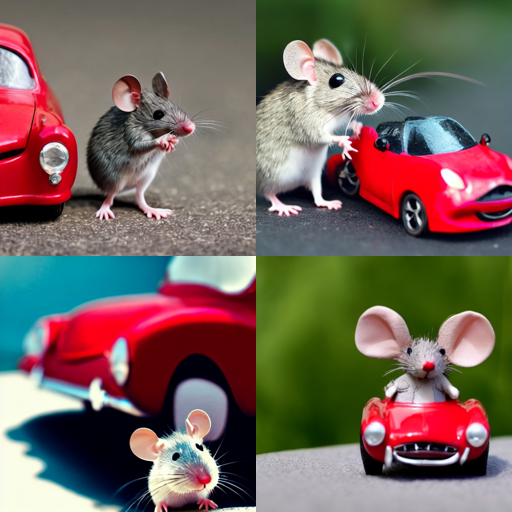

In [8]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=True
)

# Stable Diffusion 2.1

In [9]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)
tokenizer = stable.tokenizer

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'dog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'dog']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

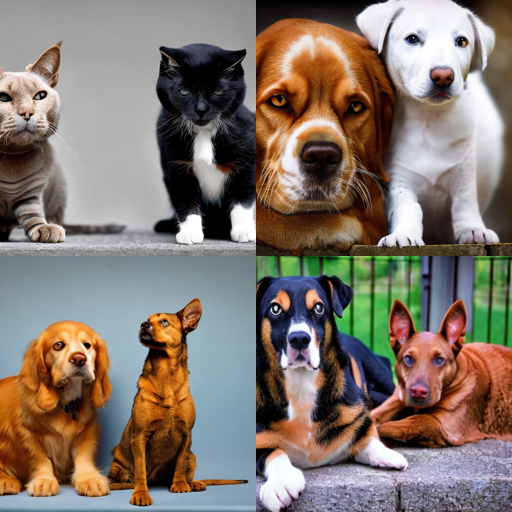

In [14]:
generate_images_for_method(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
    is_attend_and_excite=False,
    sd_2_1=True
)

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'dog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'dog']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.3958
Iteration 1 | Loss: 0.3280
Iteration 2 | Loss: 0.3427
Iteration 3 | Loss: 0.1661
Iteration 4 | Loss: 0.1190
Iteration 5 | Loss: 0.0945
Iteration 6 | Loss: 0.0955
Iteration 7 | Loss: 0.0894
Iteration 8 | Loss: 0.0798
Iteration 9 | Loss: 0.0650
Iteration 10 | Loss: 0.0674
Iteration 11 | Loss: 0.0554
Iteration 12 | Loss: 0.0626
Iteration 13 | Loss: 0.0520
Iteration 14 | Loss: 0.0562
Iteration 15 | Loss: 0.0540
Iteration 16 | Loss: 0.0580
Iteration 17 | Loss: 0.0555
Iteration 18 | Loss: 0.0591
Iteration 19 | Loss: 0.0577
Iteration 20 | Loss: 0.0603
Iteration 21 | Loss: 0.0610
Iteration 22 | Loss: 0.0623
Iteration 23 | Loss: 0.0640
Iteration 24 | Loss: 0.0669


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.4346
Iteration 1 | Loss: 0.4535
Iteration 2 | Loss: 0.4684
Iteration 3 | Loss: 0.3153
Iteration 4 | Loss: 0.1984
Iteration 5 | Loss: 0.1573
Iteration 6 | Loss: 0.1456
Iteration 7 | Loss: 0.1201
Iteration 8 | Loss: 0.1350
Iteration 9 | Loss: 0.1008
Iteration 10 | Loss: 0.1329
Iteration 11 | Loss: 0.0906
Iteration 12 | Loss: 0.1296
Iteration 13 | Loss: 0.0818
Iteration 14 | Loss: 0.1011
Iteration 15 | Loss: 0.0720
Iteration 16 | Loss: 0.0843
Iteration 17 | Loss: 0.0660
Iteration 18 | Loss: 0.0814
Iteration 19 | Loss: 0.0623
Iteration 20 | Loss: 0.0844
Iteration 21 | Loss: 0.0625
Iteration 22 | Loss: 0.0759
Iteration 23 | Loss: 0.0679
Iteration 24 | Loss: 0.0725


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.4947
Iteration 1 | Loss: 0.5245
Iteration 2 | Loss: 0.5280
Iteration 3 | Loss: 0.2731
Iteration 4 | Loss: 0.1977
Iteration 5 | Loss: 0.1962
Iteration 6 | Loss: 0.1827
Iteration 7 | Loss: 0.1865
Iteration 8 | Loss: 0.1470
Iteration 9 | Loss: 0.1522
Iteration 10 | Loss: 0.1503
Iteration 11 | Loss: 0.1438
Iteration 12 | Loss: 0.1330
Iteration 13 | Loss: 0.1239
Iteration 14 | Loss: 0.1183
Iteration 15 | Loss: 0.1111
Iteration 16 | Loss: 0.1059
Iteration 17 | Loss: 0.1010
Iteration 18 | Loss: 0.0981
Iteration 19 | Loss: 0.0967
Iteration 20 | Loss: 0.0967
Iteration 21 | Loss: 0.0975
Iteration 22 | Loss: 0.0990
Iteration 23 | Loss: 0.1005
Iteration 24 | Loss: 0.1025


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.3568
Iteration 1 | Loss: 0.3141
Iteration 2 | Loss: 0.3440
Iteration 3 | Loss: 0.1994
Iteration 4 | Loss: 0.1034
Iteration 5 | Loss: 0.0802
Iteration 6 | Loss: 0.0877
Iteration 7 | Loss: 0.0764
Iteration 8 | Loss: 0.0889
Iteration 9 | Loss: 0.0600
Iteration 10 | Loss: 0.0542
Iteration 11 | Loss: 0.0406
Iteration 12 | Loss: 0.0441
Iteration 13 | Loss: 0.0340
Iteration 14 | Loss: 0.0366
Iteration 15 | Loss: 0.0274
Iteration 16 | Loss: 0.0309
Iteration 17 | Loss: 0.0273
Iteration 18 | Loss: 0.0306
Iteration 19 | Loss: 0.0290
Iteration 20 | Loss: 0.0332
Iteration 21 | Loss: 0.0325
Iteration 22 | Loss: 0.0365
Iteration 23 | Loss: 0.0381
Iteration 24 | Loss: 0.0385


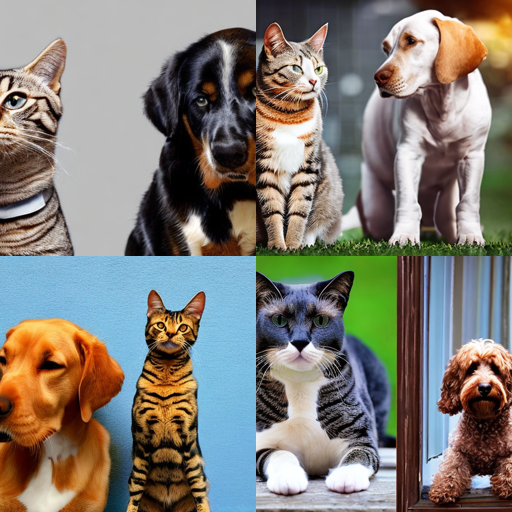

In [13]:
generate_images_for_method(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
    is_attend_and_excite=True,
    sd_2_1=True
)